## Run Network
Script for using existing network to run on cohort data

In [1]:
import os
import numpy as np
from deepcell import model_zoo
import matplotlib.pyplot as plt
import xarray as xr
import math

In [2]:
# load data
data_dir = '/data/shirley/test_points/big_test/'
cohort_xr = xr.load_dataarray(data_dir + 'Test_Points_Immune_Only.nc')

In [4]:
cohort_xr = cohort_xr[-5:]

In [3]:
# load model
experiment_folder = "20191113_Decidua_Shirley_Relabel"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
MODEL_NAME = 'Decidua_Caliban_V3_blanked_stride_0.5_convolutional_101_rf_512_dense_128_conv.h5'
weights_path = os.path.join(MODEL_DIR, MODEL_NAME)

In [4]:
run_conv_model = model_zoo.bn_feature_net_skip_2D(
    n_skips=3,
    fgbg_model=None,
    n_dense_filters=512,
    n_conv_filters=128,
    n_features=3,
    norm_method='std',
    receptive_field=101,
    last_only=False,
    n_channels=1,    
    input_shape=(1124, 1124, 6))


run_conv_model.load_weights(weights_path)

W0128 23:43:19.296339 140352523548480 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
output_array = np.zeros((cohort_xr.shape[:3] + (3,)), dtype='float32')

In [6]:
# can't load entire image at once into memory, subset into slightly overlapping regions and run through
for i in range(cohort_xr.shape[0]):
    print("predicting point {}".format(i))
    output_array[i, :1024, :1024, :] = run_conv_model.predict(cohort_xr.values[i:(i + 1), :1124, :1124, :])[-1][:, :1024, :1024, :]
    output_array[i, :1024, 1024:, :] = run_conv_model.predict(cohort_xr.values[i:(i + 1), :1124, 924:, :])[-1][:, :1024, 100:, :]
    output_array[i, 1024:, :1024, :] = run_conv_model.predict(cohort_xr.values[i:(i + 1), 924:, :1124, :])[-1][:, 100:, :1024, :]
    output_array[i, 1024:, 1024:, :] = run_conv_model.predict(cohort_xr.values[i:(i + 1), 924:, 924:, :])[-1][:, 100:, 100:, :]
    output_array[i, 1024:, 1024:, :] = run_conv_model.predict(cohort_xr.values[i:(i + 1), 924:, 924:, :])[-1][:, 100:, 100:, :]
    

predicting point 0
predicting point 1
predicting point 2
predicting point 3
predicting point 4
predicting point 5
predicting point 6
predicting point 7
predicting point 8
predicting point 9
predicting point 10
predicting point 11
predicting point 12
predicting point 13
predicting point 14
predicting point 15
predicting point 16
predicting point 17
predicting point 18
predicting point 19
predicting point 20
predicting point 21
predicting point 22
predicting point 23
predicting point 24
predicting point 25
predicting point 26
predicting point 27
predicting point 28
predicting point 29
predicting point 30
predicting point 31
predicting point 32
predicting point 33
predicting point 34
predicting point 35
predicting point 36
predicting point 37
predicting point 38
predicting point 39
predicting point 40
predicting point 41


In [7]:
output_array = output_array * 127
output_array = output_array.astype('int8')

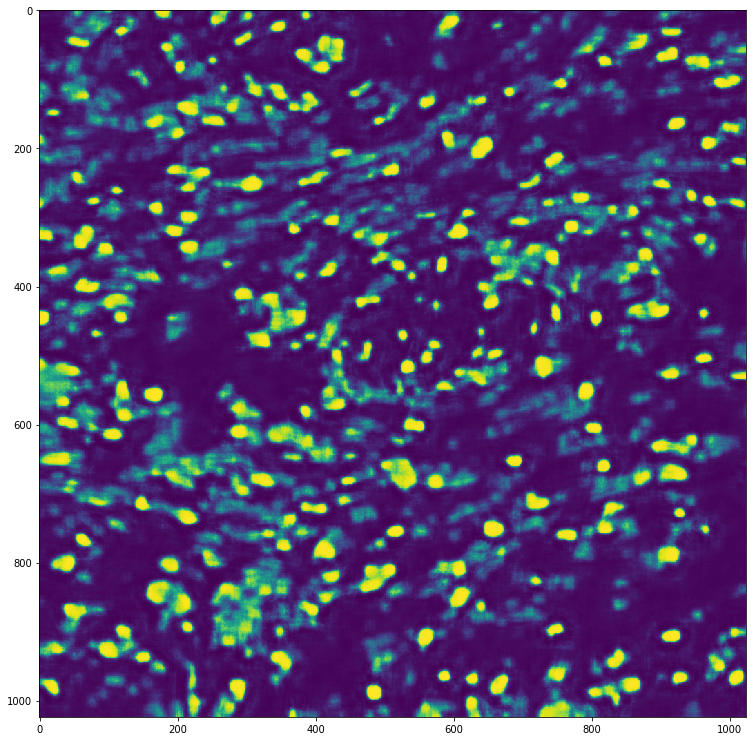

In [8]:
plt.figure(figsize = (13, 13))
plt.imshow(output_array[0, 1024:, :1024, 1])

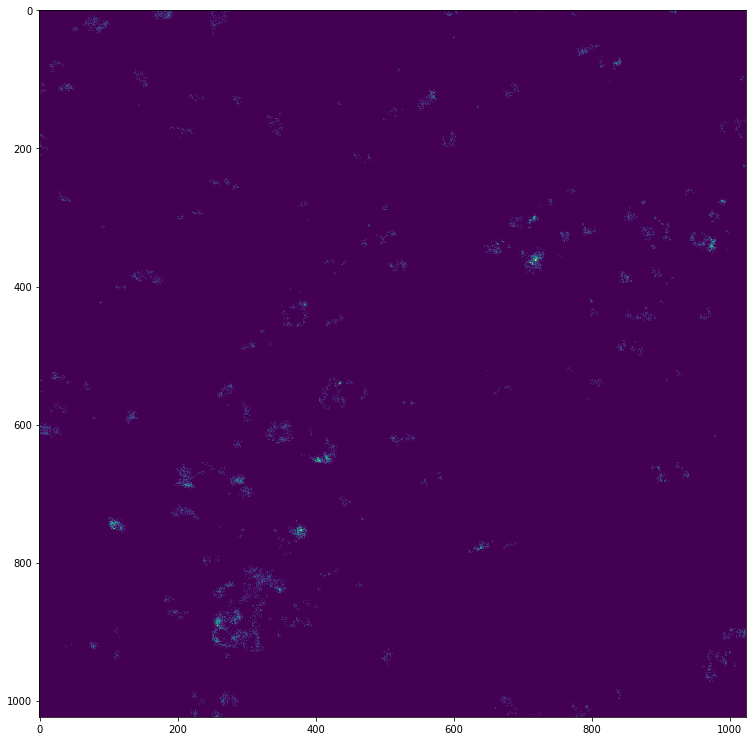

In [15]:
# no new friends
plt.figure(figsize = (13, 13))
plt.imshow(cohort_xr[0, 1024:, :1024, 5])

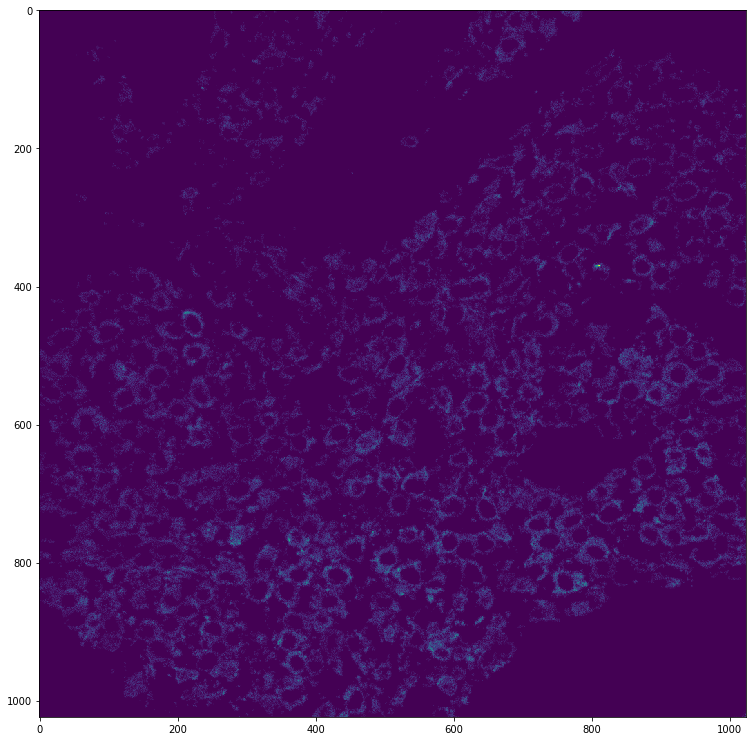

In [13]:
plt.figure(figsize = (13, 13))
plt.imshow(cohort_xr[1, :1024, :1024, 1])

In [16]:
xr_output = xr.DataArray(output_array,
                         coords=[cohort_xr.coords['points'], range(cohort_xr.shape[1]), 
                                 range(cohort_xr.shape[2]), ['border', 'interior', 'bg']],
                         dims=['points', 'rows', 'cols', 'masks'])
xr_output.to_netcdf(os.path.join(data_dir, "Decidua_Caliban_v3_immune_deepcell_output_pixel.nc"), format="NETCDF3_64BIT")


# Run watershed network

In [17]:
experiment_folder = "20191113_Decidua_Shirley_Relabel"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
MODEL_NAME = 'Decidua_Caliban_V3_blanked_stride_0.5_convolutional_watershed_101_rf_512_dense_128_conv.h5'
watershed_weights_path = os.path.join(MODEL_DIR, MODEL_NAME)

In [18]:
run_watershed_model = model_zoo.bn_feature_net_skip_2D(
    n_skips=3,
    fgbg_model=None,
    n_dense_filters=512,
    n_conv_filters=128,
    n_features=4,
    norm_method='std',
    receptive_field=101,
    last_only=False,
    n_channels=1,    
    input_shape=(1124, 1124, 6))

run_watershed_model.load_weights(watershed_weights_path)

In [19]:
output_array_watershed = np.zeros((cohort_xr.shape[:3] + (4,)))

In [20]:
# can't load entire image at once into memory, subset into slightly overlapping regions and run through
for i in range(cohort_xr.shape[0]):
    print("predicting point {}".format(i))
    output_array_watershed[i, :1024, :1024, :] = run_watershed_model.predict(cohort_xr.values[i:(i + 1), :1124, :1124, :])[-1][:, :1024, :1024, :]
    output_array_watershed[i, :1024, 1024:, :] = run_watershed_model.predict(cohort_xr.values[i:(i + 1), :1124, 924:, :])[-1][:, :1024, 100:, :]
    output_array_watershed[i, 1024:, :1024, :] = run_watershed_model.predict(cohort_xr.values[i:(i + 1), 924:, :1124, :])[-1][:, 100:, :1024, :]
    output_array_watershed[i, 1024:, 1024:, :] = run_watershed_model.predict(cohort_xr.values[i:(i + 1), 924:, 924:, :])[-1][:, 100:, 100:, :]
    

predicting point 0
predicting point 1
predicting point 2
predicting point 3
predicting point 4
predicting point 5
predicting point 6
predicting point 7
predicting point 8
predicting point 9
predicting point 10
predicting point 11
predicting point 12
predicting point 13
predicting point 14
predicting point 15
predicting point 16
predicting point 17
predicting point 18
predicting point 19
predicting point 20
predicting point 21
predicting point 22
predicting point 23
predicting point 24
predicting point 25
predicting point 26
predicting point 27
predicting point 28
predicting point 29
predicting point 30
predicting point 31
predicting point 32
predicting point 33
predicting point 34
predicting point 35
predicting point 36
predicting point 37
predicting point 38
predicting point 39
predicting point 40
predicting point 41


In [21]:
argmax_images = []
for j in range(output_array_watershed.shape[0]):
    argmax_images.append(np.argmax(output_array_watershed[j, ...], axis=-1))
argmax_images = np.array(argmax_images)

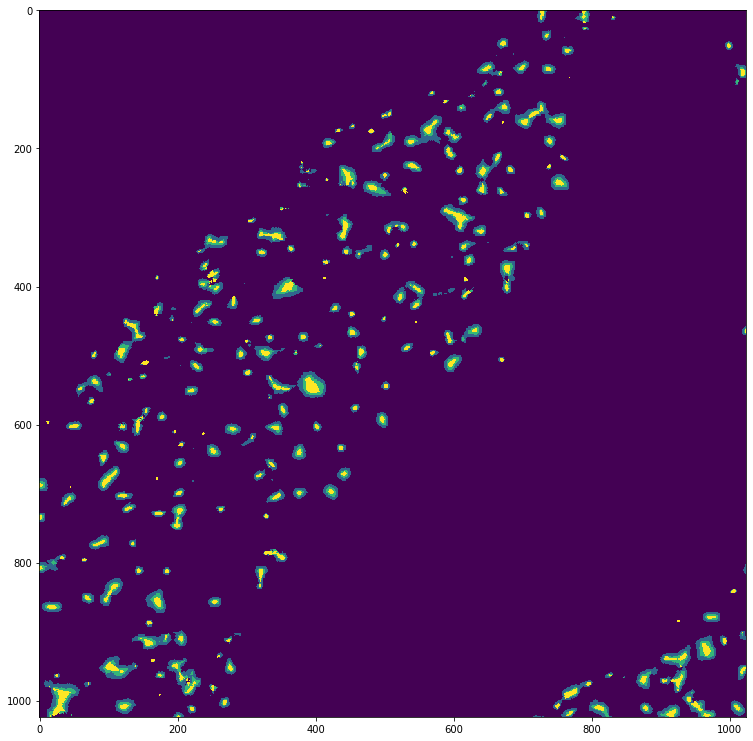

In [22]:
plt.figure(figsize = (13, 13))
plt.imshow(argmax_images[2, :1024, :1024])

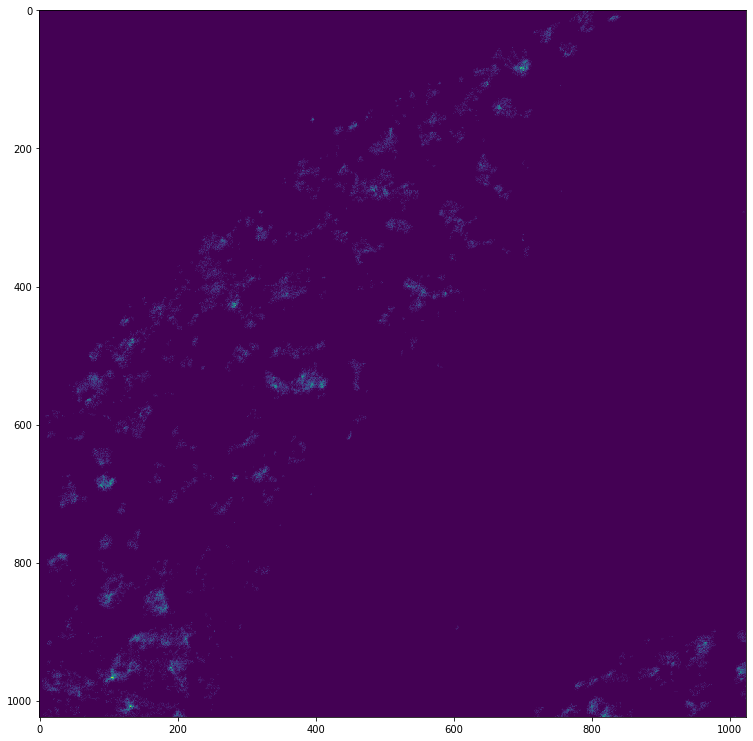

In [23]:
plt.figure(figsize = (13, 13))
plt.imshow(cohort_xr[2, :1024, :1024, 4])

In [24]:
xr_output_watershed = xr.DataArray(np.expand_dims(argmax_images, axis=-1),
                         coords=[cohort_xr.coords['points'], range(argmax_images.shape[1]), 
                                 range(argmax_images.shape[2]), ['watershed_argmax']],
                         dims=['points', 'rows', 'cols', 'masks'])
xr_output_watershed.to_netcdf(os.path.join(data_dir, "Decidua_Caliban_v3_immune_deepcell_output_watershed.nc"), format="NETCDF3_64BIT")